In [170]:
# ── Standard library
from pathlib import Path
import random
import re

# ── Third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# ── scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# ── joblib
from joblib import dump, parallel_backend

# Reproducibility seeds
np.random.seed(42)
random.seed(42)

In [171]:
## download required NLTK data files to a specific directory
# TODO: make a separate script that does this only once


NLTK_DIR = Path("../data/nltk_data")
NLTK_DIR.mkdir(parents=True, exist_ok=True)
nltk.data.path.append(str(NLTK_DIR))

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger_eng",
    "averaged_perceptron_tagger",
]

for resource in resources:
    nltk.download(resource, download_dir=str(NLTK_DIR))

print(f"NLTK data downloaded to {NLTK_DIR.resolve()}")

NLTK data downloaded to /Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/data/nltk_data


[nltk_data] Downloading package punkt to ../data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ../data/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     ../data/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ../data/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [172]:
## preprocessing function for NLTK tokenizer + lemmatizer
#TODO: move this part to preprocessing.py?

STOP_WORDS = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def nltk_preprocess(text):
    # make sure we get useful tokens
    token_pattern = re.compile(r"(?u)\b[^\W\d_]{2,}\b")  # yoinked from TfidfVectorizer
    txt = "" if not isinstance(text, str) else text.lower()
    words = token_pattern.findall(txt)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    # remove stopwords after lemmatization
    lemmatized_words = [w for w in lemmatized_words if w not in STOP_WORDS]
    return lemmatized_words

In [173]:
## get data and prepare train split and dev split

# get the combined dataset
df = pd.read_csv("../data/processed/text_combined.csv", index_col=0)

# get only train part of the dataset
df_train = df[df["split"] == "train"].reset_index(drop=True)

# get only dev part of the dataset
df_dev = df[df["split"] == "dev"].reset_index(drop=True)

# get the necessary columns out of df_train
X = df_train["text"]
y_depr = df_train["target_depr"]

print(df_train.shape)
display(df_train.head())
print(X.index.equals(y_depr.index))

# get the necessary columns out of df_dev
X_dev = df_dev["text"]
y_depr_dev = df_dev["target_depr"]

print(df_dev.shape)
display(df_dev.head())
print(X_dev.index.equals(y_depr_dev.index))

(163, 5)


,participant_id,text,target_depr,target_ptsd,split
0,302,just move around a little bit when you're fini...,0,0,train
1,303,wow okay when you're finished when she's done ...,0,0,train
2,304,so we'll just move around a little bit tonight...,0,0,train
3,305,okay looks good so we can just move around a l...,0,0,train
4,307,looking at you all right okay so now let's mak...,0,0,train


True
(56, 5)


,participant_id,text,target_depr,target_ptsd,split
0,300,so I'm going to interview in Spanish okay good...,0,0,dev
1,301,yeah there's also on Craigslist so that's why ...,0,0,dev
2,306,okay looks like we're good. Let's move around ...,0,0,dev
3,317,equipment okay how was okay thanks are you oka...,0,1,dev
4,320,perfect okay and okay and then I will let you ...,0,1,dev


True


In [84]:
y_depr.value_counts(normalize=True)

target_depr
0    0.773006
1    0.226994
Name: proportion, dtype: float64

In [ ]:
## create pipeline

pipeline = Pipeline ([
    ('vectorizer',TfidfVectorizer(
        tokenizer=nltk_preprocess, #TODO: try different tokenizers in gridsearch
        ngram_range=(1,2),
        preprocessor=None,
        lowercase=False,
        token_pattern=None,  # to use custom tokenizer, we need to disable the default token pattern
        
    )),
    ('classifier',LogisticRegression(max_iter=2000, random_state=42))
])

# Define a reproducible CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
## train 

scores = cross_val_score(pipeline, X, y_depr, cv=cv, n_jobs=-1)
print('Cross-validation scores', scores)
print('Average cross-validation score', scores.mean())

Cross-validation scores [0.78787879 0.75757576 0.75757576 0.78125    0.78125   ]
Average cross-validation score 0.7731060606060606


In [ ]:
## fit on full train
pipeline.fit(X, y_depr)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,<function nlt...t 0x1337ed300>


Classification report on dev set:
              precision    recall  f1-score    support
0              0.785714  1.000000  0.880000  44.000000
1              0.000000  0.000000  0.000000  12.000000
accuracy       0.785714  0.785714  0.785714   0.785714
macro avg      0.392857  0.500000  0.440000  56.000000
weighted avg   0.617347  0.785714  0.691429  56.000000


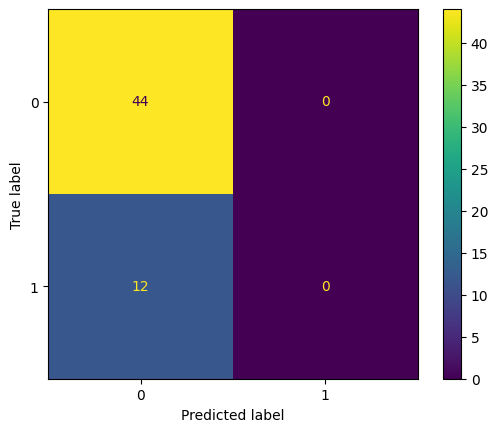

In [ ]:
## evaluate on dev set
y_pred = pipeline.predict(X_dev)

# Detailed Report on standard metrics
report_dict = classification_report(y_depr_dev, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
numeric_cols = ['precision', 'recall', 'f1-score']

print("Classification report on dev set:")
print(report_df)

# print confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_dev, y_depr_dev)
plt.show()

In [ ]:
## grid search for hyperparameter tuning

param_grid_safe = { 
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_df': [0.9],

    'classifier__penalty': ['l2'],
    'classifier__C': [0.1, 1, 5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['saga'],
}

param_grid_plus = [
    # L2: liblinear + dual
    {
        'vectorizer__min_df': [1, 2],
        'vectorizer__max_df': [0.9],

        'classifier__penalty': ['l2'],
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['liblinear'],
        'classifier__dual': [True, False], 
    },
    # L1: liblinear (no dual)
    {
        'vectorizer__min_df': [1, 2],
        'vectorizer__max_df': [0.9],

        'classifier__penalty': ['l1'],
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['liblinear'],
    },
    # ElasticNet
    {
        'vectorizer__min_df': [1, 2],
        'vectorizer__max_df': [0.9],

        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    },
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'ap': 'average_precision', 'roc': 'roc_auc'}
grid_search = GridSearchCV(
    pipeline,
    param_grid_plus,
    scoring=scoring,
    cv=cv,
    verbose=2,
    refit='ap',
)

grid_search.fit(X, y_depr)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__dual=True, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=1; total time=   3.2s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__dual=True, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=1; total time=   3.2s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__dual=True, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=1; total time=   3.2s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__dual=True, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=1; total time=   3.2s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__dual=True, classifier__penalty=l2, classifier__solver=liblinea

/Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga, vectorizer__max_df=0.9, vectorizer__min_df=2; total time=   4.0s


/Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga, vectorizer__max_df=0.9, vectorizer__min_df=2; total time=   4.1s


/Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga, vectorizer__max_df=0.9, vectorizer__min_df=2; total time=   4.0s


/Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__l1_ratio=1, classifier__penalty=elasticnet, classifier__solver=saga, vectorizer__max_df=0.9, vectorizer__min_df=2; total time=   4.0s
Best parameters found:  {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__dual': True, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1}
Best cross-validation score:  0.502035405054577


Best F1 on dev: 0.436 at threshold=0.212 (P=0.279, R=1.000)
Threshold for recall≥0.70: 0.194


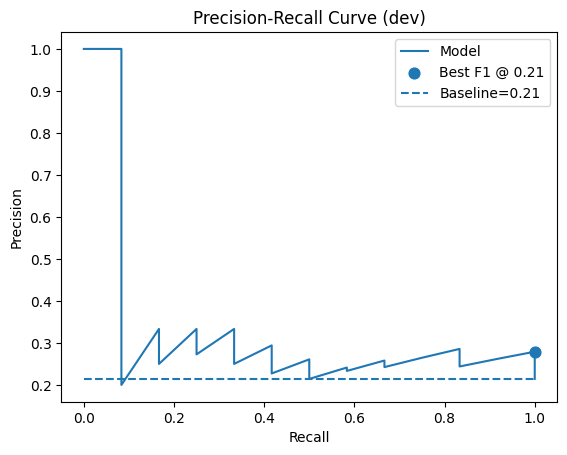

              precision    recall  f1-score   support

           0      1.000     0.295     0.456        44
           1      0.279     1.000     0.436        12

    accuracy                          0.446        56
   macro avg      0.640     0.648     0.446        56
weighted avg      0.846     0.446     0.452        56



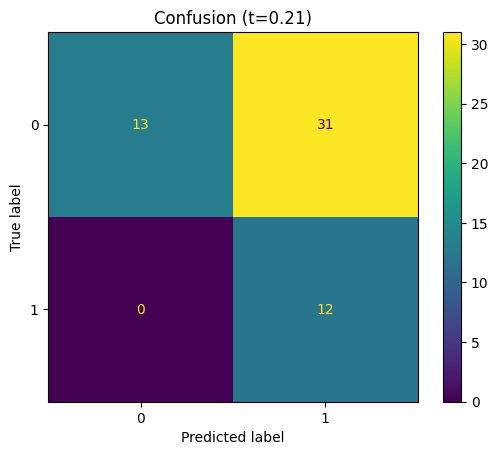

In [181]:
## determine the best threshold 

best_estimator = grid_search.best_estimator_
# y_prob_dev — probas on dev; y_depr_dev — labels 0/1
y_prob_dev = best_estimator.predict_proba(X_dev)[:, 1]
prec, rec, thr = precision_recall_curve(y_depr_dev, y_prob_dev)

# a) max F1 over PR-curve
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.argmax(f1[:-1])       
best_threshold = float(thr[best_idx])
print(f"Best F1 on dev: {f1[best_idx]:.3f} at threshold={best_threshold:.3f} (P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

# b) min threshold for recall (example: ≥0.70)
target_recall = 0.70
idx = np.where(rec[:-1] >= target_recall)[0]
t_recall = float(thr[idx[0]]) if len(idx) else 0.5
print(f"Threshold for recall≥{target_recall:.2f}: {t_recall:.3f}")

# plot precision-recall curve and highlight the best f1 model
plt.figure()
plt.plot(rec, prec, label="Model")
plt.scatter(rec[best_idx], prec[best_idx], s=60, zorder=5, label=f"Best F1 @ {best_threshold:.2f}")
plt.hlines(np.mean(y_depr_dev), 0, 1, linestyles='dashed', label=f"Baseline={np.mean(y_depr_dev):.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.title("Precision-Recall Curve (dev)")
plt.show()

# report and confusion matrix with chosen threshold
y_pred = (y_prob_dev >= best_threshold).astype(int)
print(classification_report(y_depr_dev, y_pred, digits=3))
cm = confusion_matrix(y_depr_dev, y_pred, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format='d'); plt.title(f"Confusion (t={best_threshold:.2f})"); plt.show()


In [ ]:
## save grid search results
pd.DataFrame(grid_search.cv_results_).to_csv("baseline_grid_cv_results.csv", index=False)

# save the best model
best_estimator.set_params(vectorizer__tokenizer=nltk_preprocess)
dump((best_estimator,  {"threshold": best_threshold}), "baseline_best_model.joblib")

print("Model and threshold saved.")

Model and threshold saved.


In [185]:
## load the best model from baseline_best_model.joblib

try:
    from joblib import load
    baseline_best_model = load("baseline_best_model.joblib") 
    print("Loaded successfully.")
except Exception as e:
    print("Load failed:", repr(e))

Loaded successfully.


In [187]:
baseline_best_model

(Pipeline(steps=[('vectorizer',
                  TfidfVectorizer(lowercase=False, max_df=0.9,
                                  ngram_range=(1, 2), token_pattern=None,
                                  tokenizer=<function nltk_preprocess at 0x131ab7560>)),
                 ('classifier',
                  LogisticRegression(C=1, dual=True, max_iter=2000,
                                     random_state=42, solver='liblinear'))]),
 {'threshold': 0.21209494824179617})